Project 1: Identify bank card numbers

In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

1. Processing digital templates

Divided into three steps:

    1. Preprocess the image (grayscale, binary)
    2. Calculate to find the contour of each number and sort it
    3. Cut the small photos of each number and save them in a dictionary (key = value)

In [18]:
def cv_show(name,img):
    cv2.imshow(name,img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
def sort_contours(cnts, method = 'left-to-right'):
    reverse = False
    i = 0
    if method == 'right-to-left' or method == 'bottom-to-top':
        reverse = True
    if method == 'top-to-bottom' or method == 'bottom-to-top':
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    # Use a smallest rectangle to hug the found shape x, y, w, h
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key = lambda b:b[1][i], reverse = reverse))
    # b:d[1][i] is sorted by the x value in boungdingBoxes
    return cnts, boundingBoxes
# Defines a function that scales up or down an image
def resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    resized = cv2.resize(image, dim, interpolation = inter)
    return resized
#boundingBoxes = [cv2.boundingRect(c) for c in cnts]
#Equivalent to 
#boundingBoxes = []
#for c in cnts:
#   boundingBoxes.append(cv2.boundingRect(c))

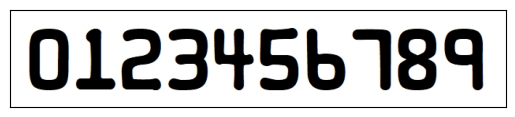

In [19]:
# Read a template image
numbers = cv2.imread("C:/Computer_Vision/OpenCV-Python/references/numbers.png")
#cv_show('Original Template Image', img)
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(numbers, cv2.COLOR_BGR2RGB))
plt.show()

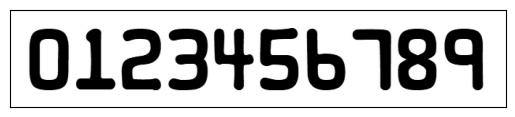

In [20]:
# Grayscale image
ref = cv2.cvtColor(numbers, cv2.COLOR_BGR2GRAY)
#cv_show('Grayscale Image', ref)
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
plt.show()

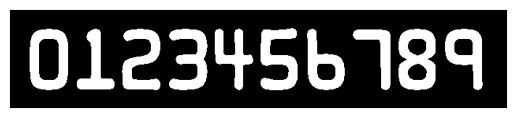

In [21]:
# Binary processing
ref = cv2.threshold(ref, 10, 255, cv2.THRESH_BINARY_INV)[1]
#cv_show('BINARY_INV Image', ref)
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
plt.show()

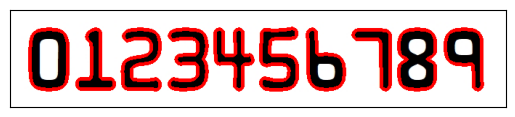

In [22]:
# Calculate outline
# cv2.findCountours() function are binary images, The parameters received black and white, not grayscale images.
# cv2.RETR_EXTERNAL only detects the outer contour
# cv2.CHAIN_APPROX_SIMPLE only retains the end point coordinates
# Each element in the returned list is an outline in the image
refCnts, hierarchy = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(numbers, refCnts, -1, (0, 0, 255), 3)
#cv_show('Draw Contours Image', img)
#refCnts
# Sort from left to right, top to bottom
refCnts = sort_contours(refCnts, method = 'left-to-right')[0]
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(numbers, cv2.COLOR_BGR2RGB))
plt.show()

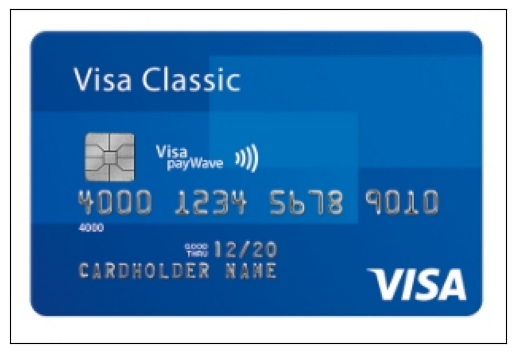

In [23]:
# Traverse every contour
digits = {}
for (i, c) in enumerate(refCnts):
    # Calculate the bounding rectangle and resize it to the appropriate size
    (x, y, w, h) = cv2.boundingRect(c)
    roi = ref[y:y + h, x:x + w]
    roi = cv2.resize(roi, (57,88))
    # Each number corresponds to each template
    digits[i] = roi
# Initialize the convolution kernel
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
# Read the input image and preprocess it
card = cv2.imread('C:/Computer_Vision/OpenCV-Python/references/card.png')
#cv_show('Card Original Image', image)
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(card, cv2.COLOR_BGR2RGB))
plt.show()

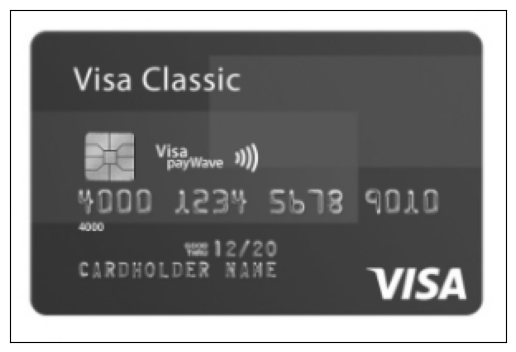

In [24]:
image = resize(card, width = 300) # adjust size
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Grayscale
#cv_show('Grayscale Card Image', gray)
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
plt.show()

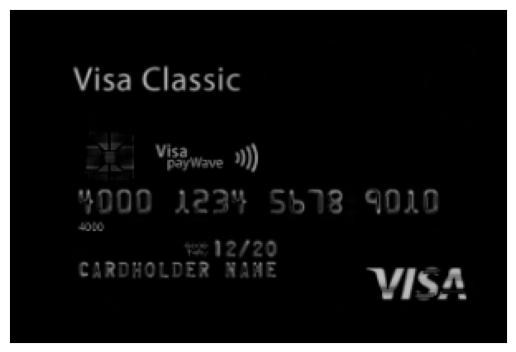

In [25]:
# Top hat operation to highlight brighter areas
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)
#cv_show('Tophat Card Image', tophat)
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(tophat, cv2.COLOR_BGR2RGB))
plt.show()

(201, 300)


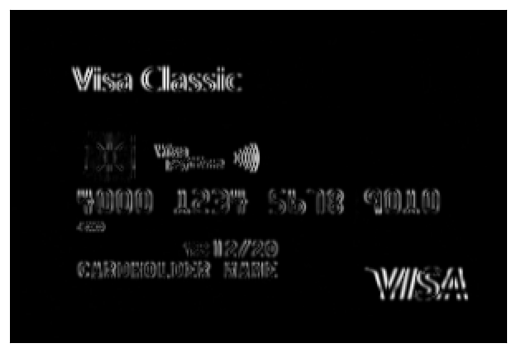

In [26]:
gradX = cv2.Sobel(tophat, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
# Find the gradient in the horizontal direction and detect edges
# Ksize = -1 is equivalent to using a 3*3 Scharr filter
gradX = np.absolute(gradX) # Absolute value
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal))) # Normalize
gradX = gradX.astype('uint8') # Round off the decimal part of a value
print(np.array(gradX).shape)
#cv_show('gradX', gradX)
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(gradX, cv2.COLOR_BGR2RGB))
plt.show()

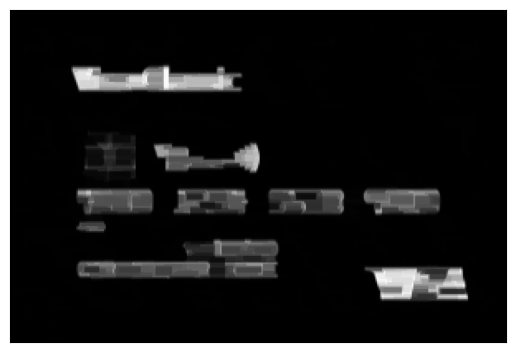

In [27]:
# Connect the numbers together through a closing operation (first dilation, then erosion)
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
#cv_show('gradX Closing', gradX)
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(gradX, cv2.COLOR_BGR2RGB))
plt.show()

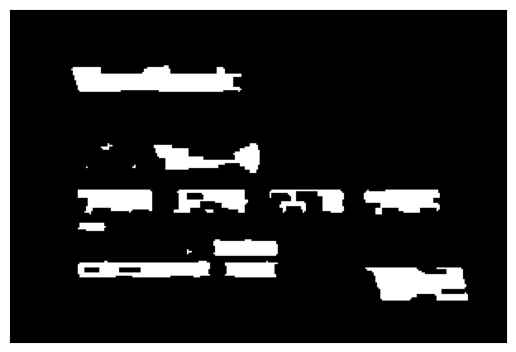

In [28]:
# HRESH_OTSU will automatically find a suitable threshold, suitable for double peaks, and the threshold parameter needs to be set to 0
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
#cv_show('Thresh', thresh)
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
plt.show()

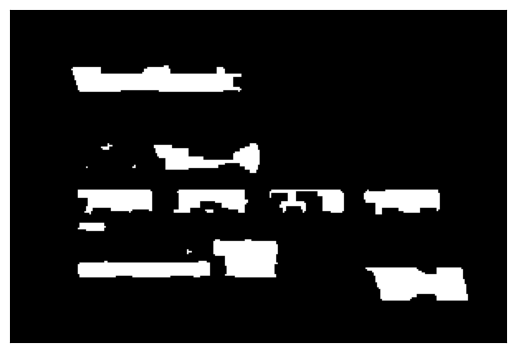

In [29]:
# Another closing operation
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
#cv_show('Thresh Again', thresh)
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
plt.show()

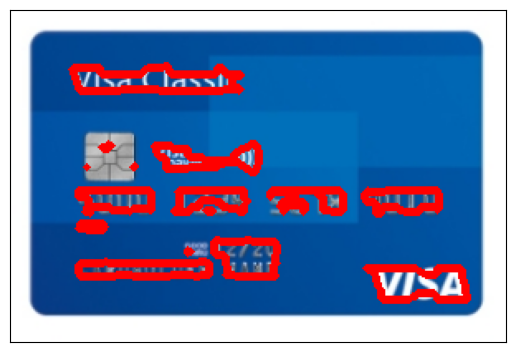

In [30]:
# Calculate contour
threshCnts, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = threshCnts # Extract all contours in the image
cur_img = image.copy()
cv2.drawContours(cur_img, cnts, -1, (0, 0, 255), 3) #画出轮廓
#cv_show('Contoured Card Image', cur_img)
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB))
plt.show()

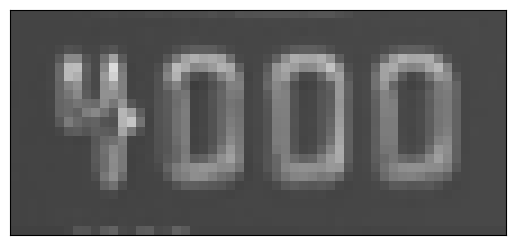

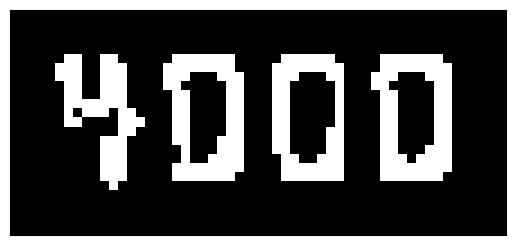

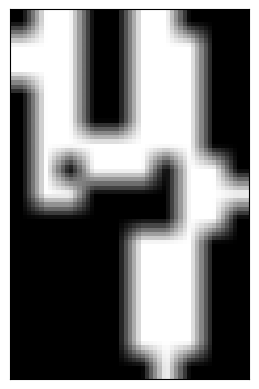

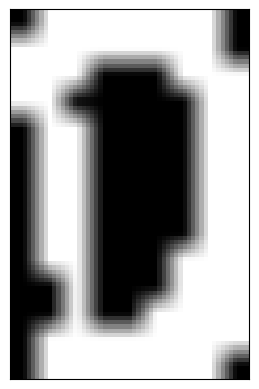

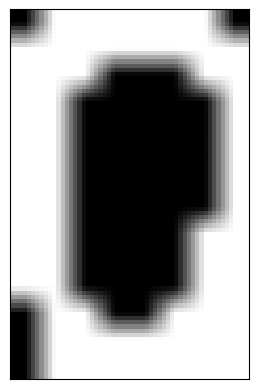

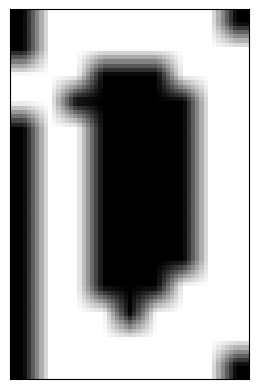

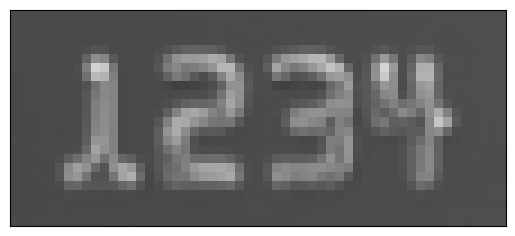

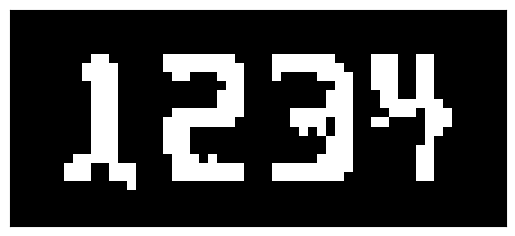

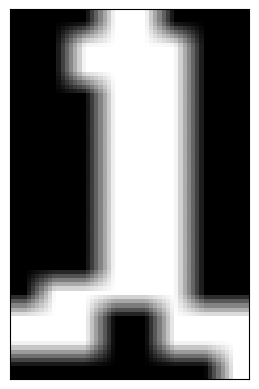

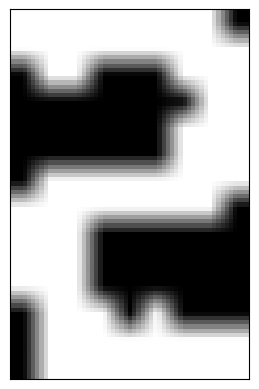

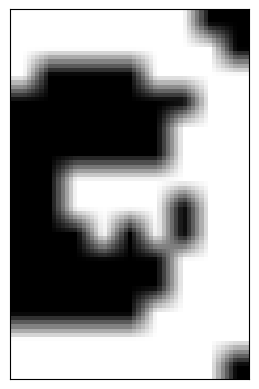

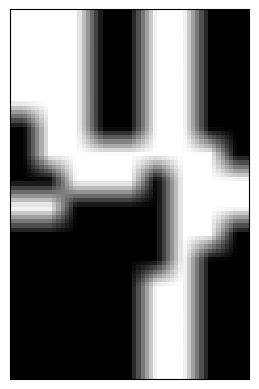

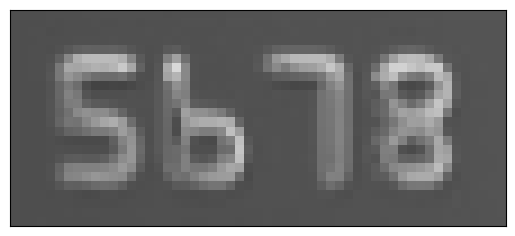

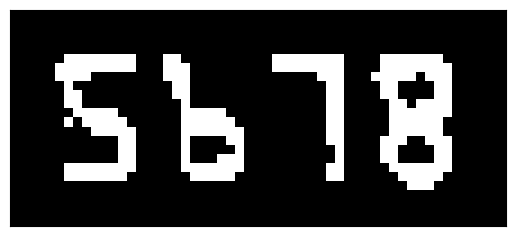

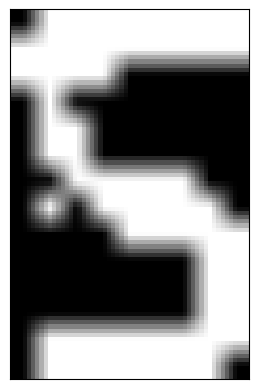

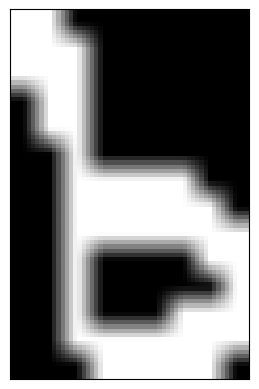

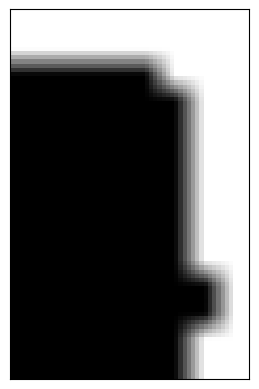

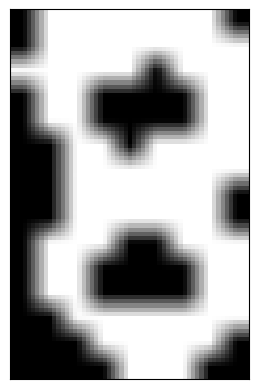

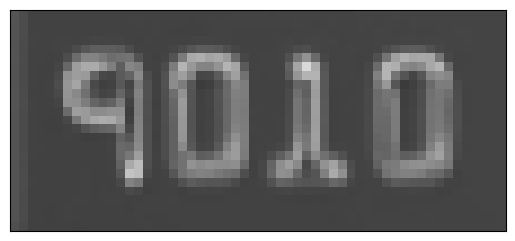

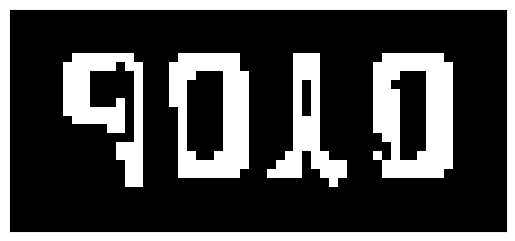

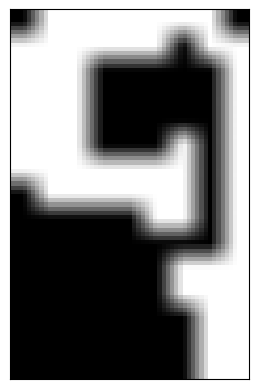

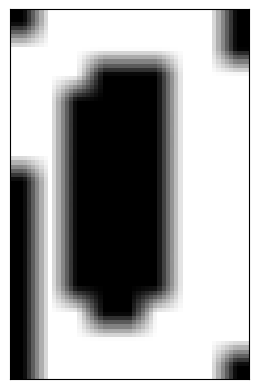

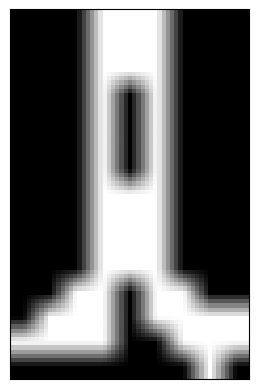

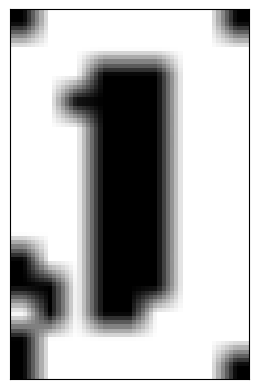

In [31]:
locs = []
# Traverse contours
for (i, c) in enumerate(cnts):
    # Calculate rectangle
    (x, y, w, h) = cv2.boundingRect(c) # Get contour information
    ar = w / float(h)
    # Calculate the ratio of width to length (if it is not a card number, the aspect ratio is generally different and can be filtered)
    # Choose the appropriate area based on the actual task. Basically, there are four numbers in each group.
    if ar > 2.5 and ar < 4.0:
        if (w > 40 and w < 55) and (h > 10 and h < 20):
            # Keep the ones that fit (here are four groups of serialized card number outlines)
            locs.append((x, y, w, h))
# Sort the matching outlines from left to right according to the abscissa size so that they are the same as the card number.
locs = sorted(locs, key = lambda x:x[0])
output = []
# Facilitate numbers in each outline
for (i, (gx, gy, gw, gh)) in enumerate(locs):
    # Iterate over the numbers in each contour
    # Store the numbers in each contour and add them to the final result list.
    groupOutput = []
    # Extract each group based on coordinates
    group = gray[gy - 5:gy + gh + 5, gx - 5:gx + gw + 5]
    #cv_show('group', group)
    plt.xticks([]), plt.yticks([])
    plt.imshow(cv2.cvtColor(group, cv2.COLOR_BGR2RGB))
    plt.show()
    # Preprocessing
    group = cv2.threshold(group, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    #cv_show('group', group)
    plt.xticks([]), plt.yticks([])
    plt.imshow(cv2.cvtColor(group, cv2.COLOR_BGR2RGB))
    plt.show()
    # Calculate the contour of each group
    digitCnts, hierarchy = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    digitCnts = sort_contours(digitCnts, method = 'left-to-right')[0]
    # Calculate each value in each group
    for c in digitCnts:
    # Contour to current value, resize or appropriate size
        (x, y, w, h) = cv2.boundingRect(c)
        roi = group[y:y + h, x:x + w]
        roi = cv2.resize(roi, (57, 88))
        #cv_show('roi', roi)
        plt.xticks([]), plt.yticks([])
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.show()    
        # Calculate match score
        scores = []
        # Calculate each score in the template
        for (digit, digitROI) in digits.items():
        # Template matching
            result = cv2.matchTemplate(roi, digitROI, cv2.TM_CCOEFF)
        # The larger the number, the higher the score and the better the match.
            (_, score, _, _) = cv2.minMaxLoc(result)
            scores.append(score)
        
        # Return the index of the maximum value in scores[] and add it to the list
        groupOutput.append(str(np.argmax(scores)))
    # draw it
    cv2.rectangle(image, (gx - 5, gy - 5), (gx + gw + 5, gy + gh + 5), (0, 0, 255), 1)
    cv2.putText(image, ''.join(groupOutput), (gx, gy - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)
    # final result
    output.extend(groupOutput)

Credit Card #:4000123456739010


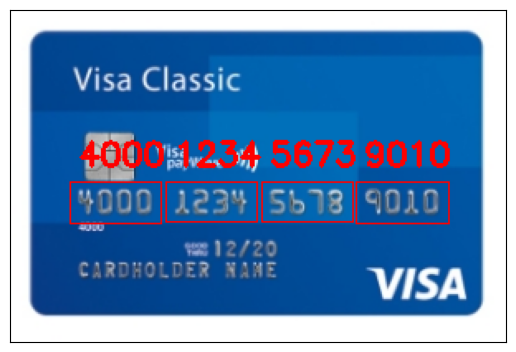

In [32]:
# print the result
print('Credit Card #:{}'.format(''.join(output)))
#cv_show('Image', image)
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()